In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

In [3]:
def time_filter(time, start, stop, strength):
    
    
    
    return sf.expit( strength*(time-start)  ) * (1 -sf.expit( strength*(time- stop)  ) )
    

<IPython.core.display.Javascript object>


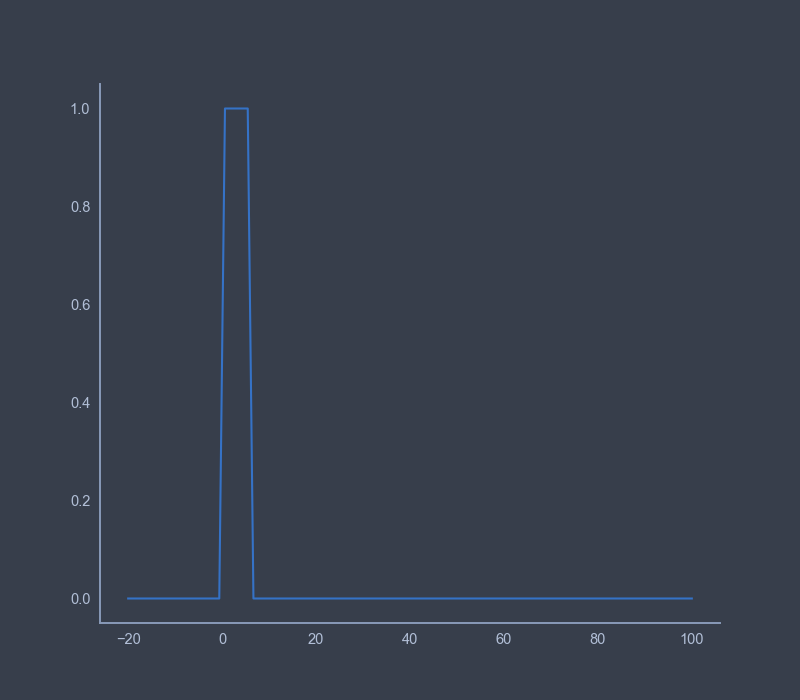

In [4]:
fig, ax = plt.subplots()


xx = np.linspace(-20,100,100)



y = time_filter(xx, 0, 6, 100)


ax.plot(xx, y)


In [2]:
#copy_template()

<IPython.core.display.Javascript object>


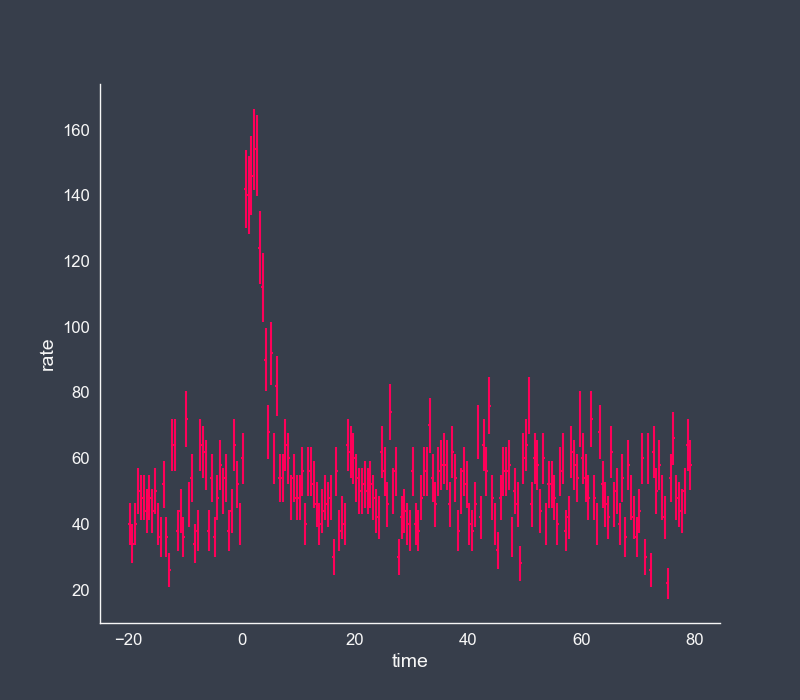

<IPython.core.display.Javascript object>


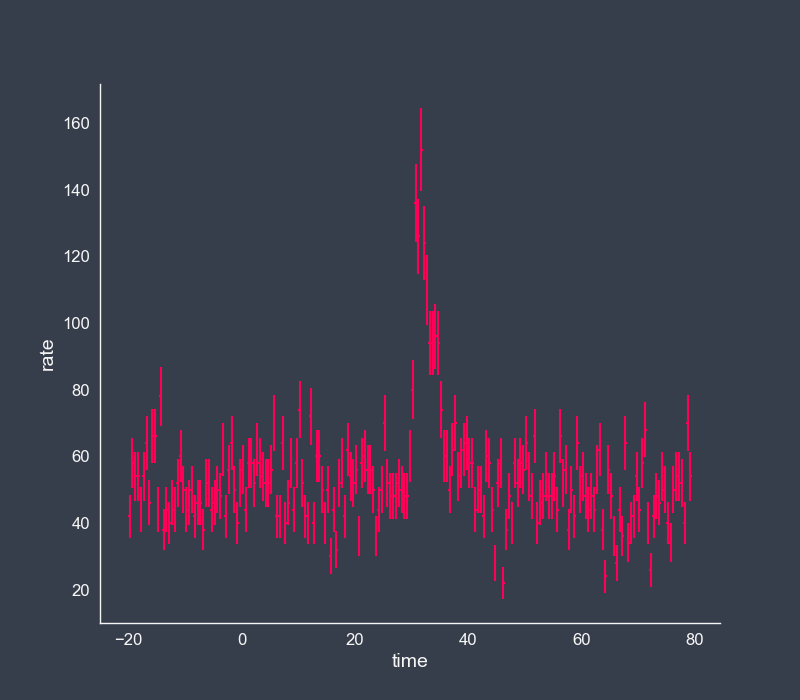

In [15]:
with plt.style.context('mike_dark'):

    uni = Universe.from_yaml('template_config.yaml')
    uni.explode_grb(tstart=-50,tstop=100)
    for det, lc in uni.light_curves.items():

        lc.display(-20,80,.5,color=red)



In [6]:
uni._time_differences

0.
29.64412906


In [16]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-19.4,40.4,1.)
mid = np.mean([times[:-1],times[1:]], axis=0)

lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,80,1)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
k=50

N_model = 200

predict_time = np.linspace(-20,80,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            bw=.2,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time
           
           
           
           )

In [36]:
model = stan_utility.compile_model('rff.stan', model_name='rff')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_99c8df28a55942f0f8c35127d952c985 NOW.


In [37]:
fit = model.sampling(warmup=2000,iter=2500,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

<IPython.core.display.Javascript object>


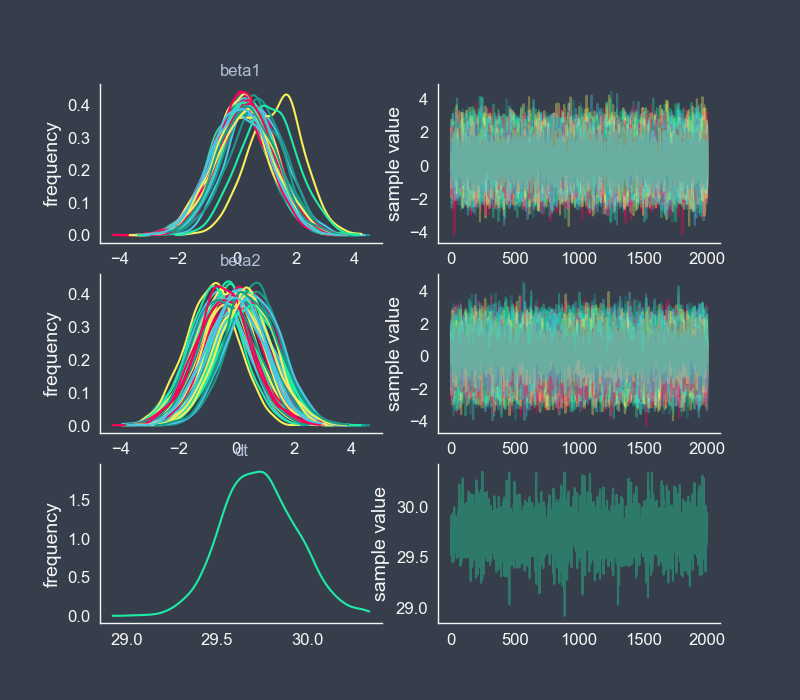

In [38]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt'
             
             ]);

<IPython.core.display.Javascript object>


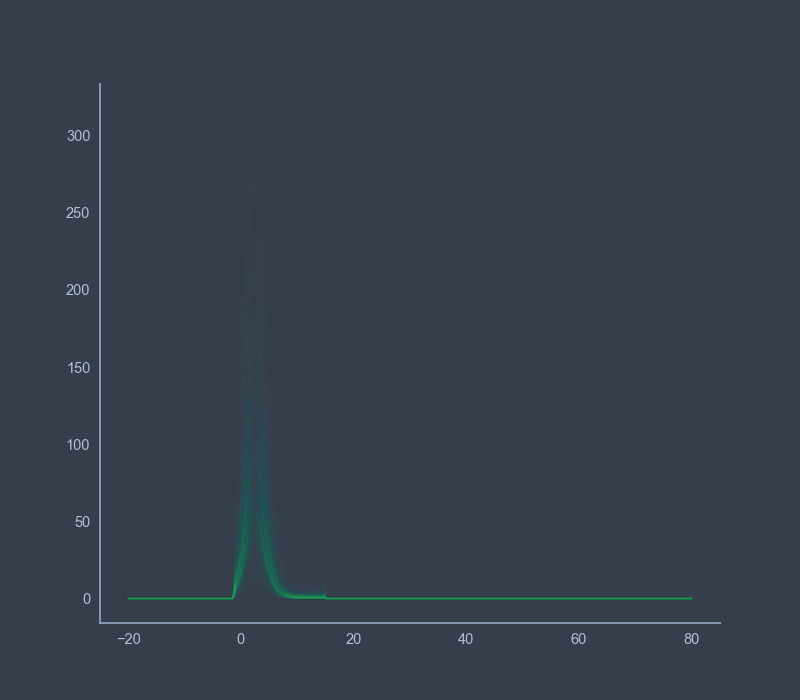

In [39]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::10]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


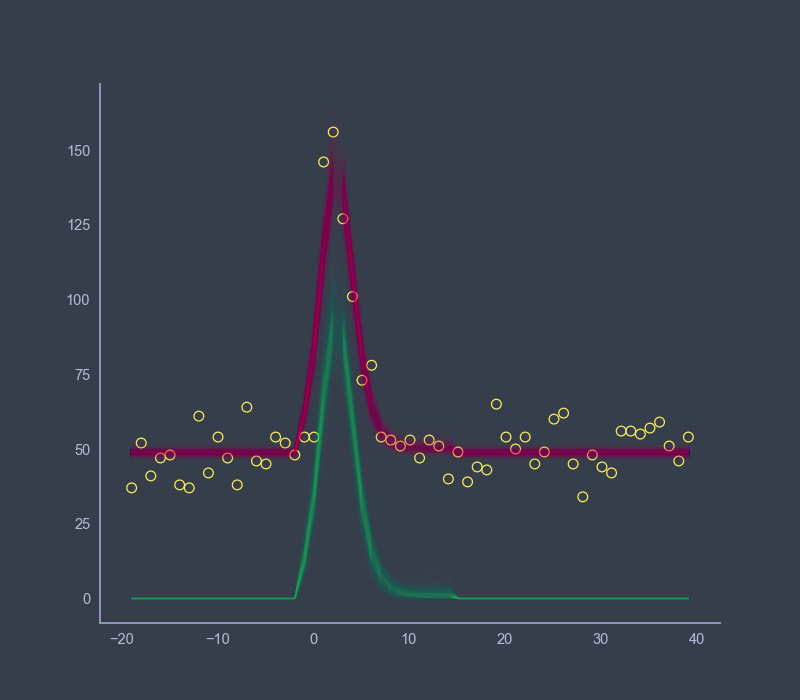

In [40]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, y + b, alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


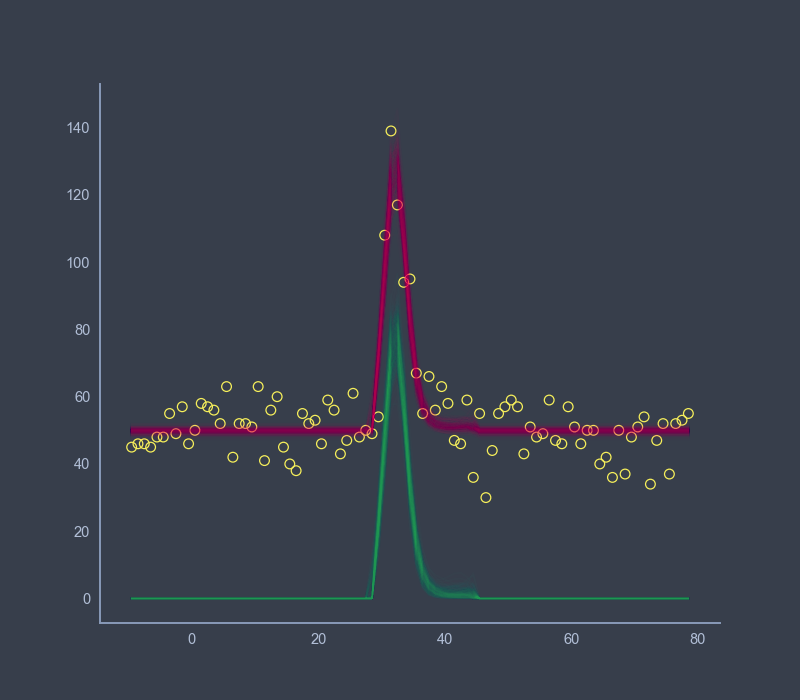

In [41]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


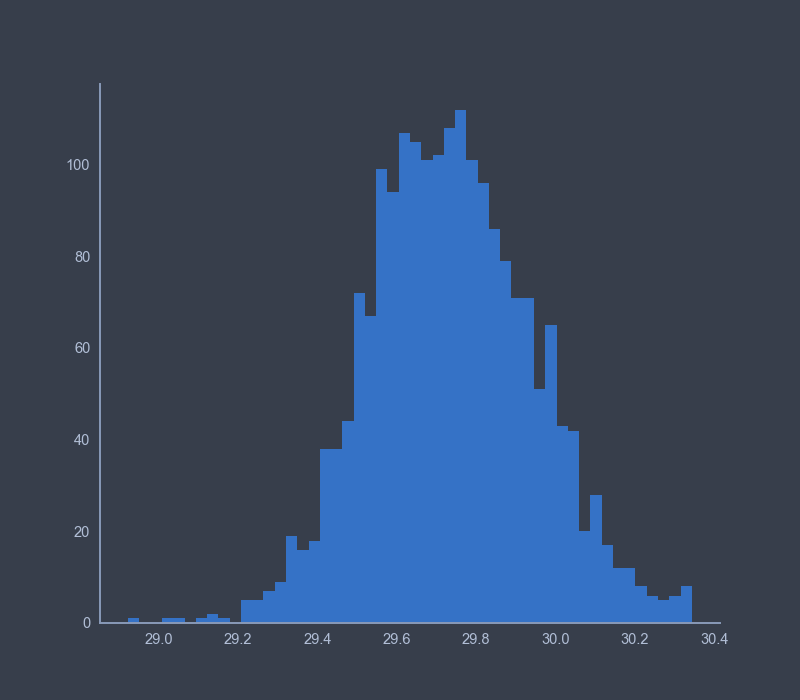

(array([  1.,   0.,   0.,   1.,   1.,   0.,   1.,   2.,   1.,   0.,   5.,
          5.,   7.,   9.,  19.,  16.,  18.,  38.,  38.,  44.,  72.,  67.,
         99.,  94., 107., 105., 101., 102., 108., 112., 101.,  96.,  86.,
         79.,  71.,  71.,  51.,  65.,  43.,  42.,  20.,  28.,  17.,  12.,
         12.,   8.,   6.,   5.,   6.,   8.]),
 array([28.9233505 , 28.95175739, 28.98016429, 29.00857118, 29.03697807,
        29.06538497, 29.09379186, 29.12219876, 29.15060565, 29.17901254,
        29.20741944, 29.23582633, 29.26423322, 29.29264012, 29.32104701,
        29.3494539 , 29.3778608 , 29.40626769, 29.43467459, 29.46308148,
        29.49148837, 29.51989527, 29.54830216, 29.57670905, 29.60511595,
        29.63352284, 29.66192974, 29.69033663, 29.71874352, 29.74715042,
        29.77555731, 29.8039642 , 29.8323711 , 29.86077799, 29.88918488,
        29.91759178, 29.94599867, 29.97440557, 30.00281246, 30.03121935,
        30.05962625, 30.08803314, 30.11644003, 30.14484693, 30.17325382,
 

In [44]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


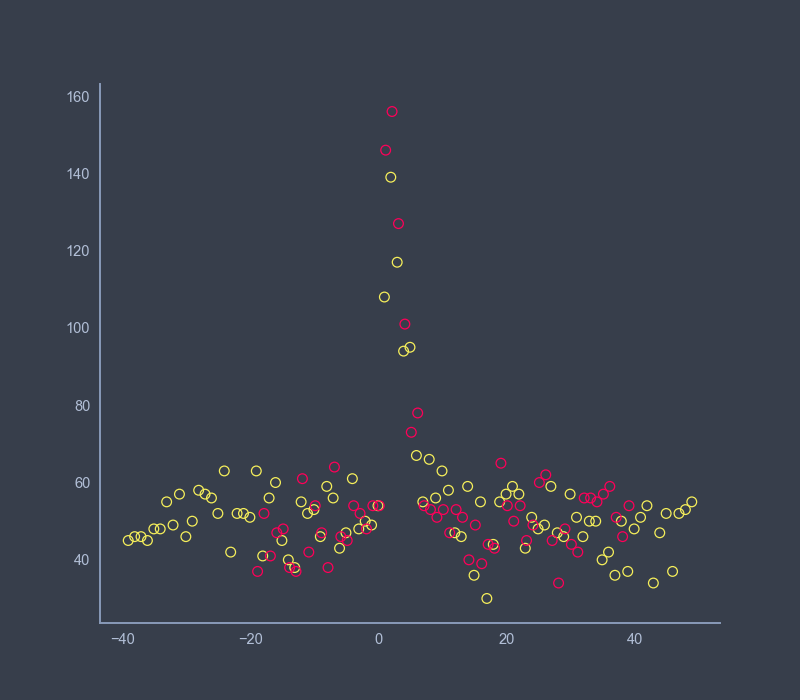

In [25]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2 -dt, counts2 , edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts , edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


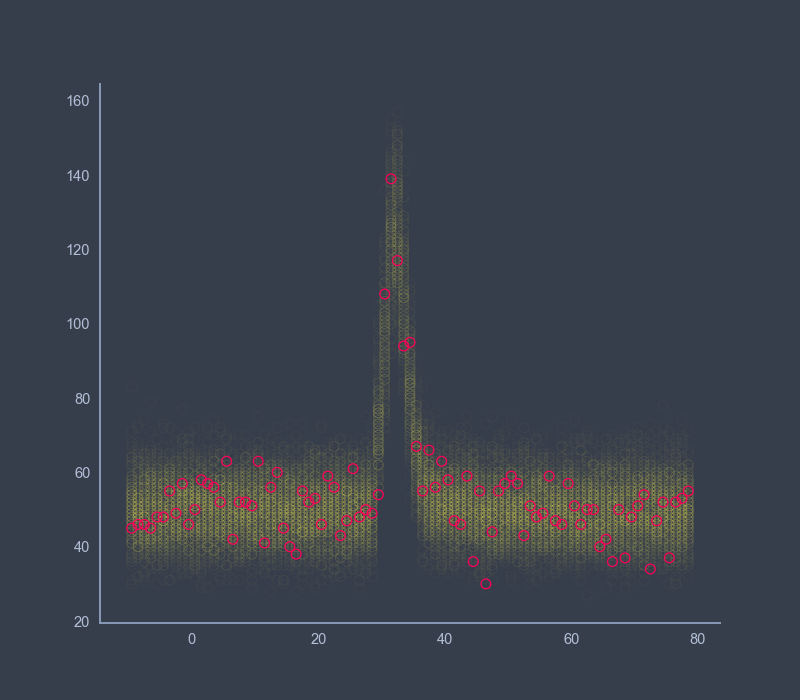

In [42]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


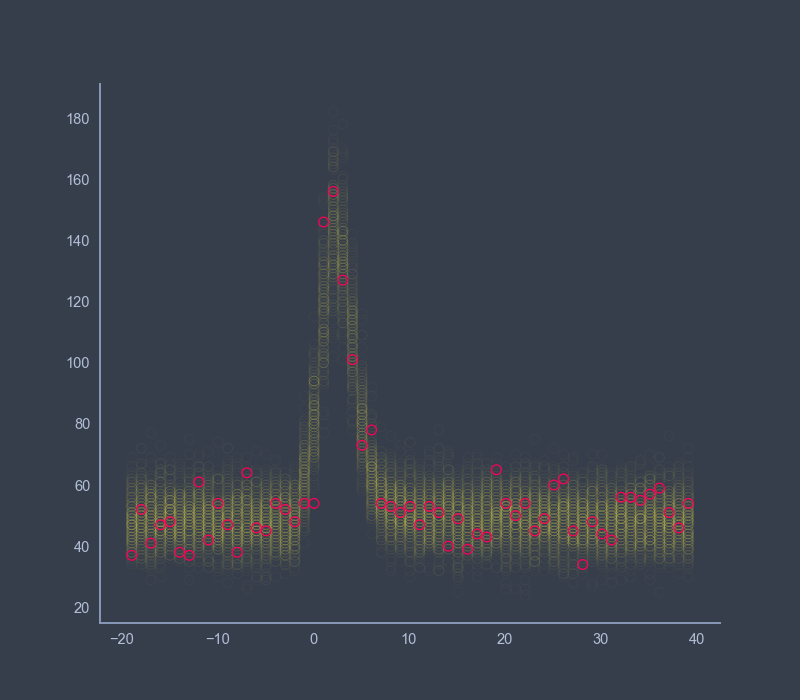

In [43]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)